In [1]:
# импортируем библиотеки
import requests
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import dash
from dash import dcc
from dash import html

In [2]:
# получаем данные визитов и регистраций по API
visits = requests.get('https://data-charts-api.hexlet.app/visits?begin=2023-03-01&end=2023-09-01')
visits_json = visits.json()

regs = requests.get('https://data-charts-api.hexlet.app/registrations?begin=2023-03-01&end=2023-09-01')
regs_json = regs.json()

In [3]:
# преобразовываем в таблицы
df_vis = pd.DataFrame(visits_json)
df_regs = pd.DataFrame(regs_json)

In [4]:
# избавляемся от времени в колонках 'datetime'
df_vis['date_group'] = pd.to_datetime(df_vis['datetime'])
df_vis['date_group'] = df_vis['date_group'].dt.date

df_regs['date_group'] = pd.to_datetime(df_regs['datetime'])
df_regs['date_group'] = df_regs['date_group'].dt.date

In [5]:
# удаляем ботов в визитах
df_vis = df_vis[~df_vis['user_agent'].str.contains('bot')]

In [6]:
# берем последний визит,группируем и считаем таблицу с визитами
visits_clean = df_vis.loc[df_vis.groupby('visit_id')['datetime'].idxmax()]
visits = visits_clean.groupby(['date_group', 'platform'])['visit_id'].agg('count')

In [7]:
# группируем и считаем таблицу с регистрациями
regs_itog = df_regs.groupby(['date_group', 'platform'])['user_id'].agg('count')

In [8]:
# объединяем визиты и регистрации
merged_df = pd.merge(visits, regs_itog, left_index=True, right_index=True, how='outer')

In [9]:
# переименовываем колонки
merged_df = merged_df.rename(columns={'visit_id': 'visits', 'user_id': 'registrations'})

In [10]:
# считаем конверсию
merged_df['conversion'] = round(merged_df['registrations']*100 / merged_df['visits'], 2)
merged_df = merged_df.reset_index()
merged_df

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.33
1,2023-03-01,ios,22,18,81.82
2,2023-03-01,web,279,8,2.87
3,2023-03-02,android,67,59,88.06
4,2023-03-02,ios,31,24,77.42
...,...,...,...,...,...
547,2023-08-30,ios,66,40,60.61
548,2023-08-30,web,1227,34,2.77
549,2023-08-31,android,57,42,73.68
550,2023-08-31,ios,50,36,72.00


In [11]:
# сохраняем итоги
merged_df.to_json('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/conversion.json')

In [12]:
# читаем таблицу с рекламой, избавляемся от времени
ads_df = pd.read_csv('ads.csv')
ads_df['date'] = pd.to_datetime(ads_df['date'])
ads_df['date'] = ads_df['date'].dt.date
ads_df.head()

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01,google,cpc,advanced_algorithms_series,212
1,2023-03-02,google,cpc,advanced_algorithms_series,252
2,2023-03-03,google,cpc,advanced_algorithms_series,202
3,2023-03-04,google,cpc,advanced_algorithms_series,223
4,2023-03-05,google,cpc,advanced_algorithms_series,265


In [13]:
# соединяем таблицу конверсий и данные по рекламе
data = pd.merge(merged_df, ads_df, left_on='date_group', right_on='date', how='inner')
# Заполним пустые значения 0 для cost и none для utm_campaign
data['cost'].fillna(0)
data['utm_campaign'].fillna('None')
# выбираем необходимые столбцы
data = data[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]
data

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,75,61,212,advanced_algorithms_series
1,2023-03-01,22,18,212,advanced_algorithms_series
2,2023-03-01,279,8,212,advanced_algorithms_series
3,2023-03-02,67,59,252,advanced_algorithms_series
4,2023-03-02,31,24,252,advanced_algorithms_series
...,...,...,...,...,...
421,2023-08-30,66,40,109,intro_to_python_course
422,2023-08-30,1227,34,109,intro_to_python_course
423,2023-08-31,57,42,215,intro_to_python_course
424,2023-08-31,50,36,215,intro_to_python_course


In [14]:
data.to_json('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/ads.json')

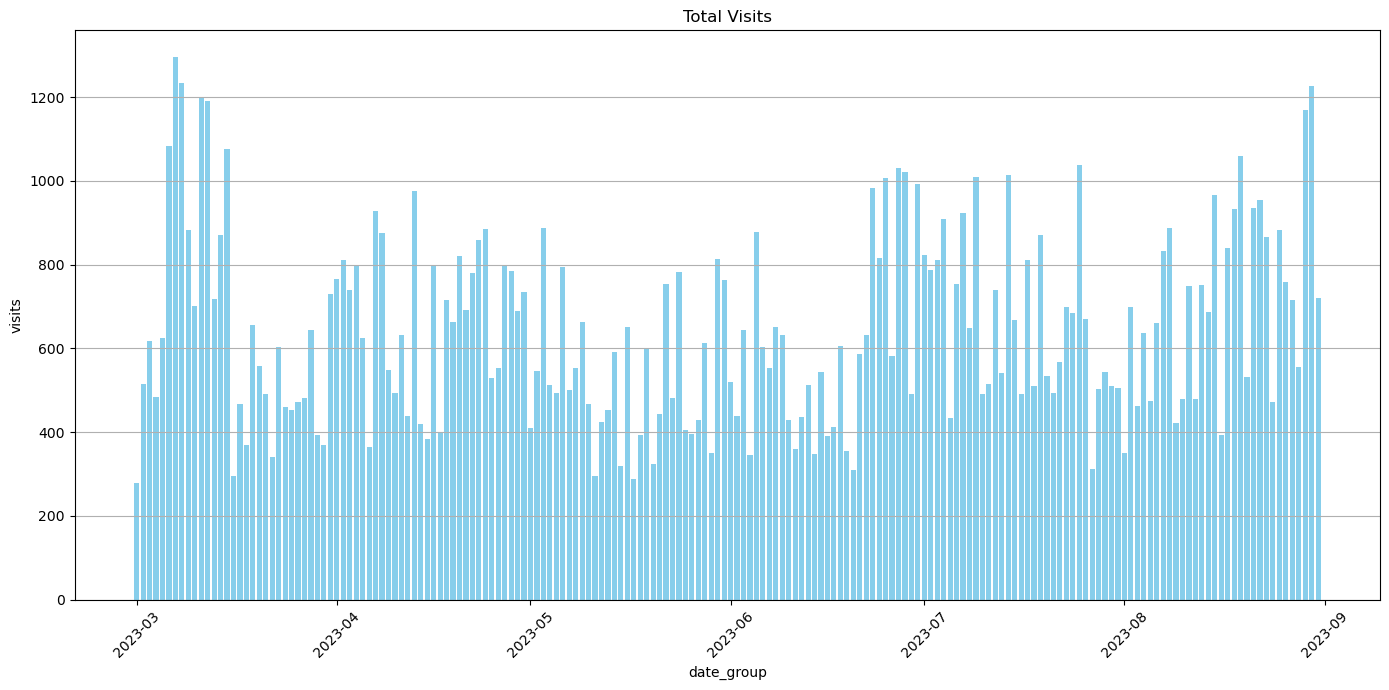

In [88]:
# итоговые визиты
plt.figure(figsize=(14, 7))
bars = plt.bar(merged_df['date_group'], merged_df['visits'], color='skyblue')
plt.xlabel('date_group')
plt.ylabel('visits')
plt.title('Total Visits')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/total visits.png')

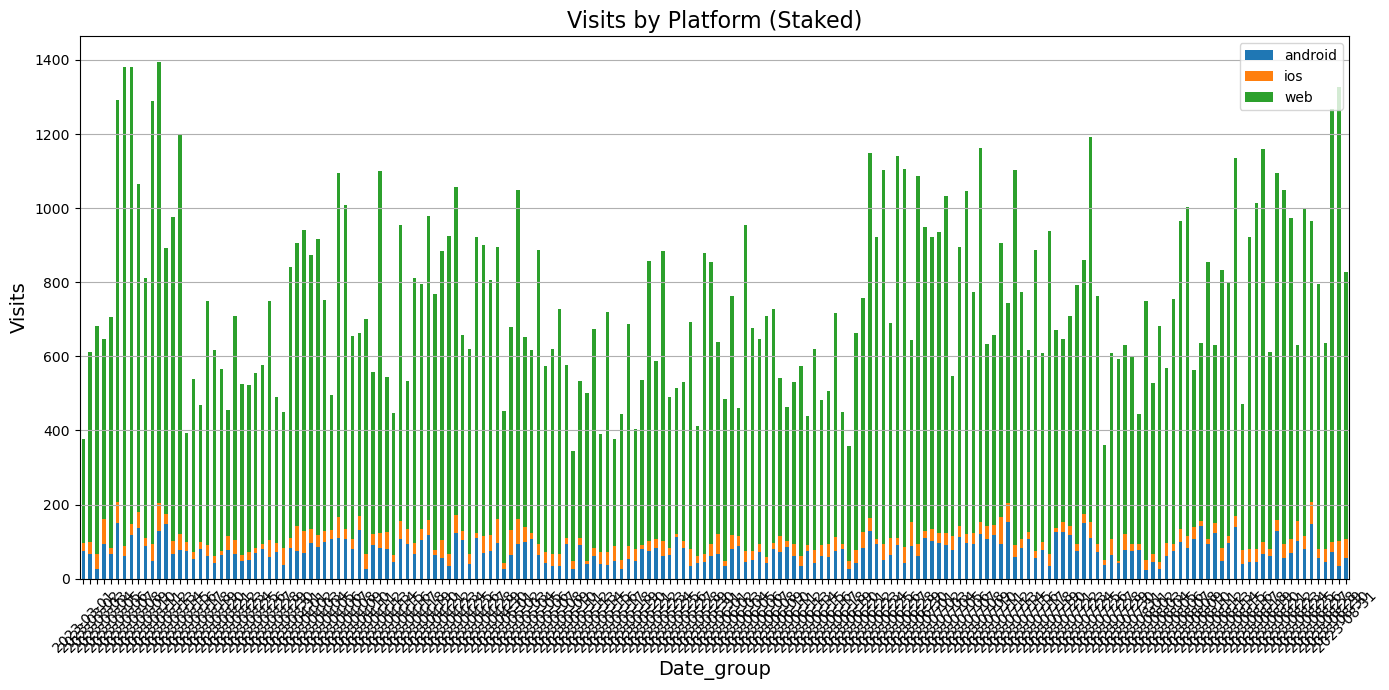

In [16]:
# итоговые визиты с разбивкой по платформам
def total_visits_pltfm_chart(df):
    fig, ax = plt.subplots(figsize=(14,7))
    df = merged_df.pivot_table(index='date_group', columns='platform', values='visits')
    df.plot(kind='bar', stacked=True, ax=ax)
    plt.title('Visits by Platform (Staked)', fontsize=16)
    plt.xlabel('Date_group',fontsize=14)
    plt.ylabel('Visits',fontsize=14)
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/visits by platforms.png')
    plt.show()

total_visits_pltfm_chart(data)

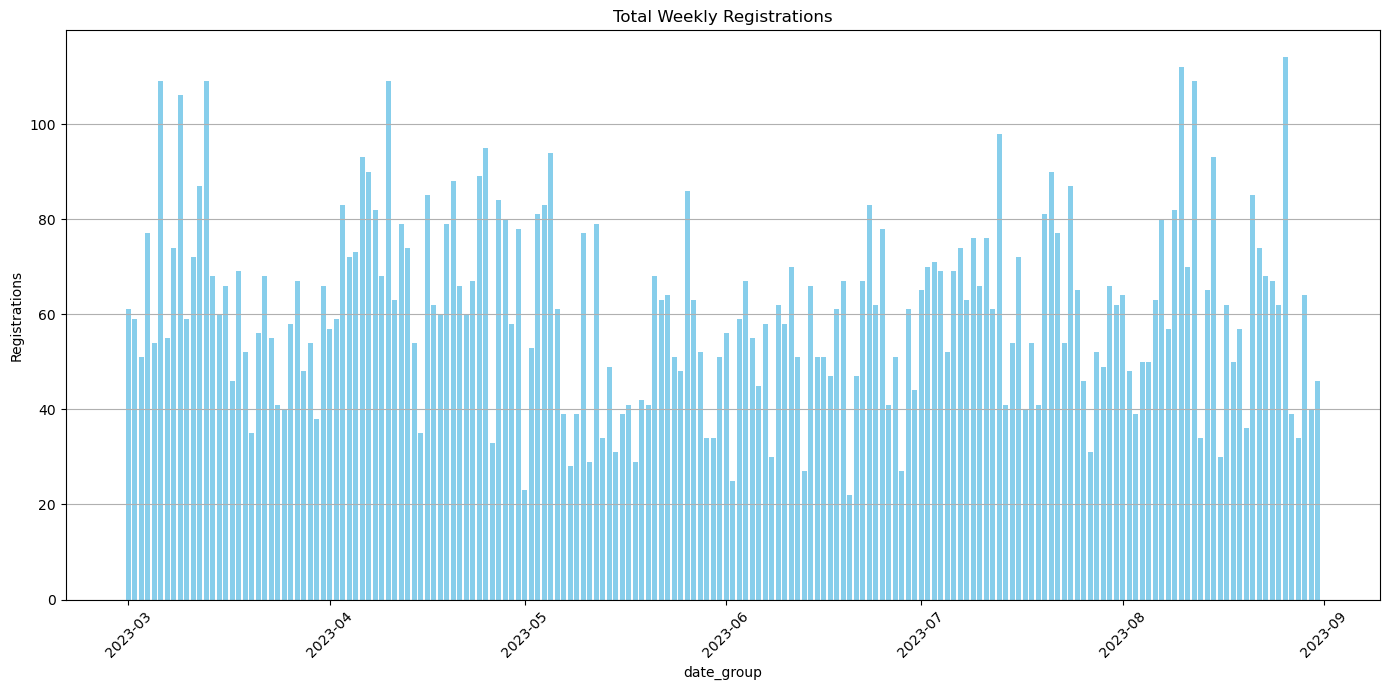

In [90]:
# итоговые регистрации
plt.figure(figsize=(14, 7))
bars = plt.bar(merged_df['date_group'], merged_df['registrations'], color='skyblue')
plt.xlabel('date_group')
plt.ylabel('Registrations')
plt.title('Total Weekly Registrations')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/total registrations.png')

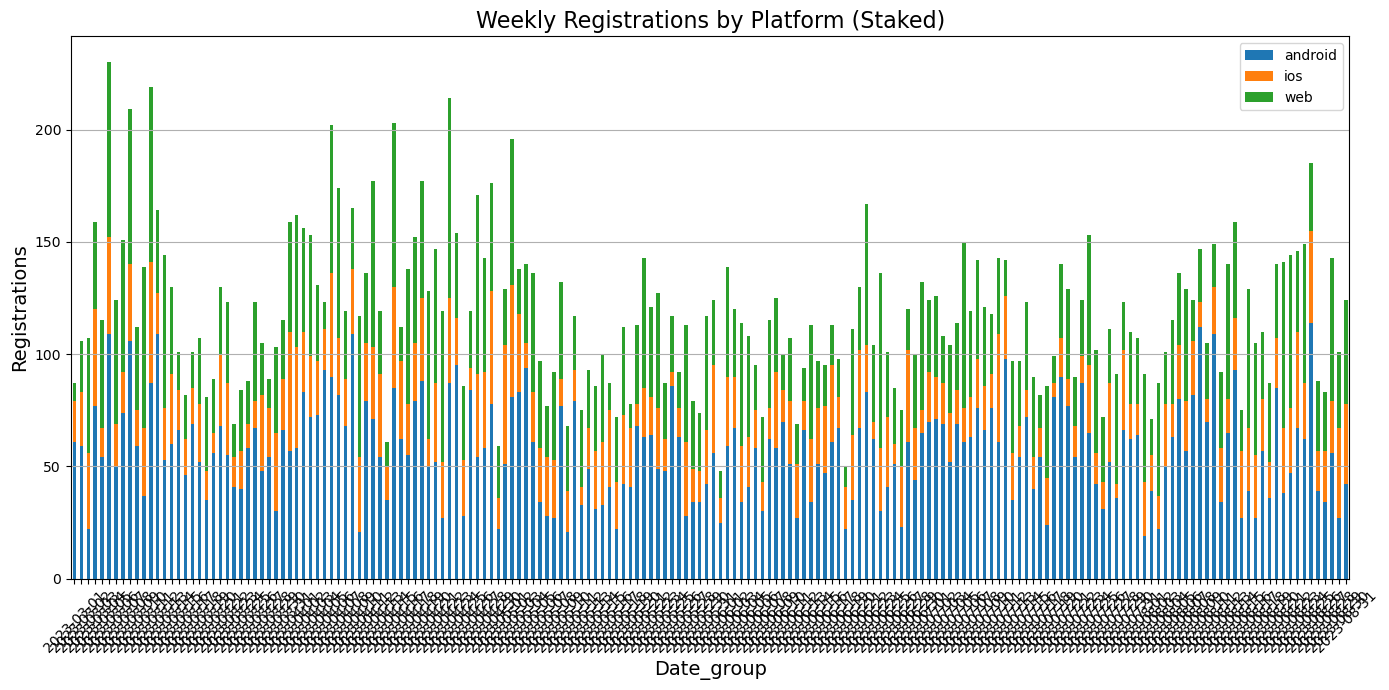

In [18]:
# итоговые регистрации с разбивкой по платформе
def total_visits_pltfm_chart(df):
    fig, ax = plt.subplots(figsize=(14,7))
    df = merged_df.pivot_table(index='date_group', columns='platform', values='registrations')
    df.plot(kind='bar', stacked=True, ax=ax)
    plt.title('Weekly Registrations by Platform (Staked)', fontsize=16)
    plt.xlabel('Date_group',fontsize=14)
    plt.ylabel('Registrations',fontsize=14)
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/regs by platforms.png')
    plt.show()

total_visits_pltfm_chart(data)

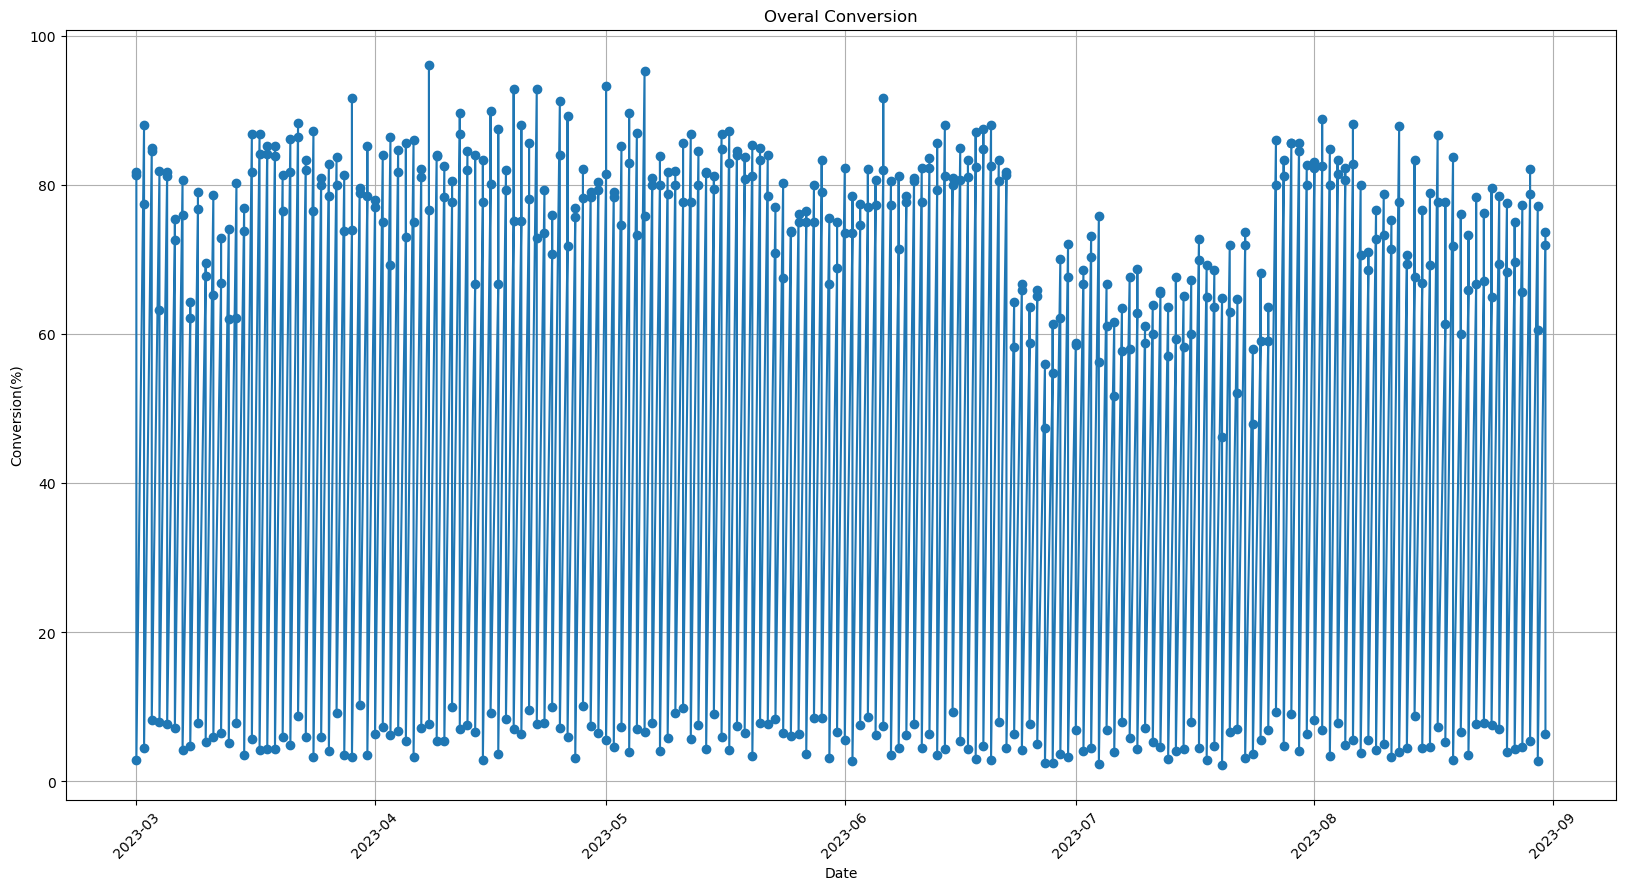

In [70]:
# итоговые конверсии
plt.figure(figsize=(20, 10))
plt.title('Overal Conversion', fontsize=12)
x = merged_df['date_group']
y = merged_df['conversion']
plt.plot(x, y, marker="o")
plt.title('Overal Conversion')
plt.xlabel('Date')
plt.ylabel('Conversion(%)')
plt.xticks(rotation = 45)
plt.grid()
plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/conversion by campaign.png')
plt.show()

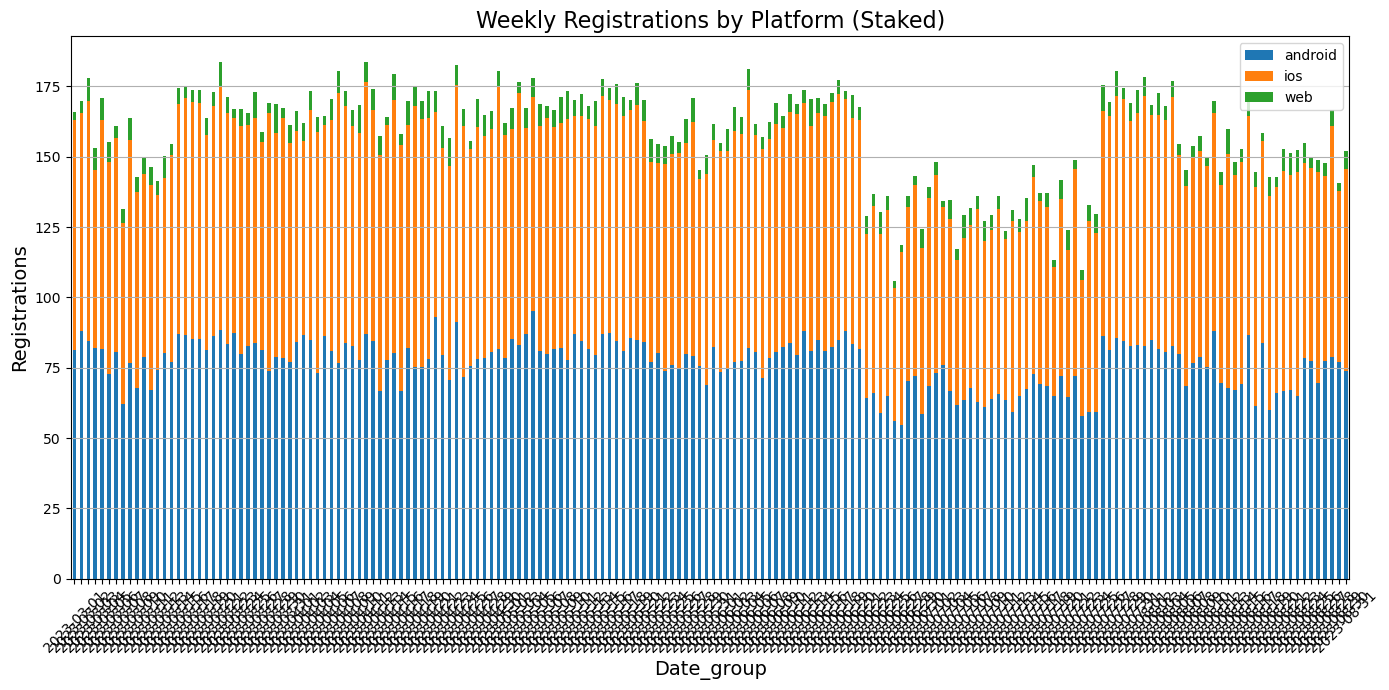

In [20]:
def agg_conversion_chart(df):
    fig, ax = plt.subplots(figsize=(14,7))
    df = merged_df.pivot_table(index='date_group', columns='platform', values='conversion')
    df.plot(kind='bar', stacked=True, ax=ax)
    plt.title('Weekly Registrations by Platform (Staked)', fontsize=16)
    plt.xlabel('Date_group',fontsize=14)
    plt.ylabel('Registrations',fontsize=14)
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/regs by platforms.png')
    plt.show()

agg_conversion_chart(merged_df)

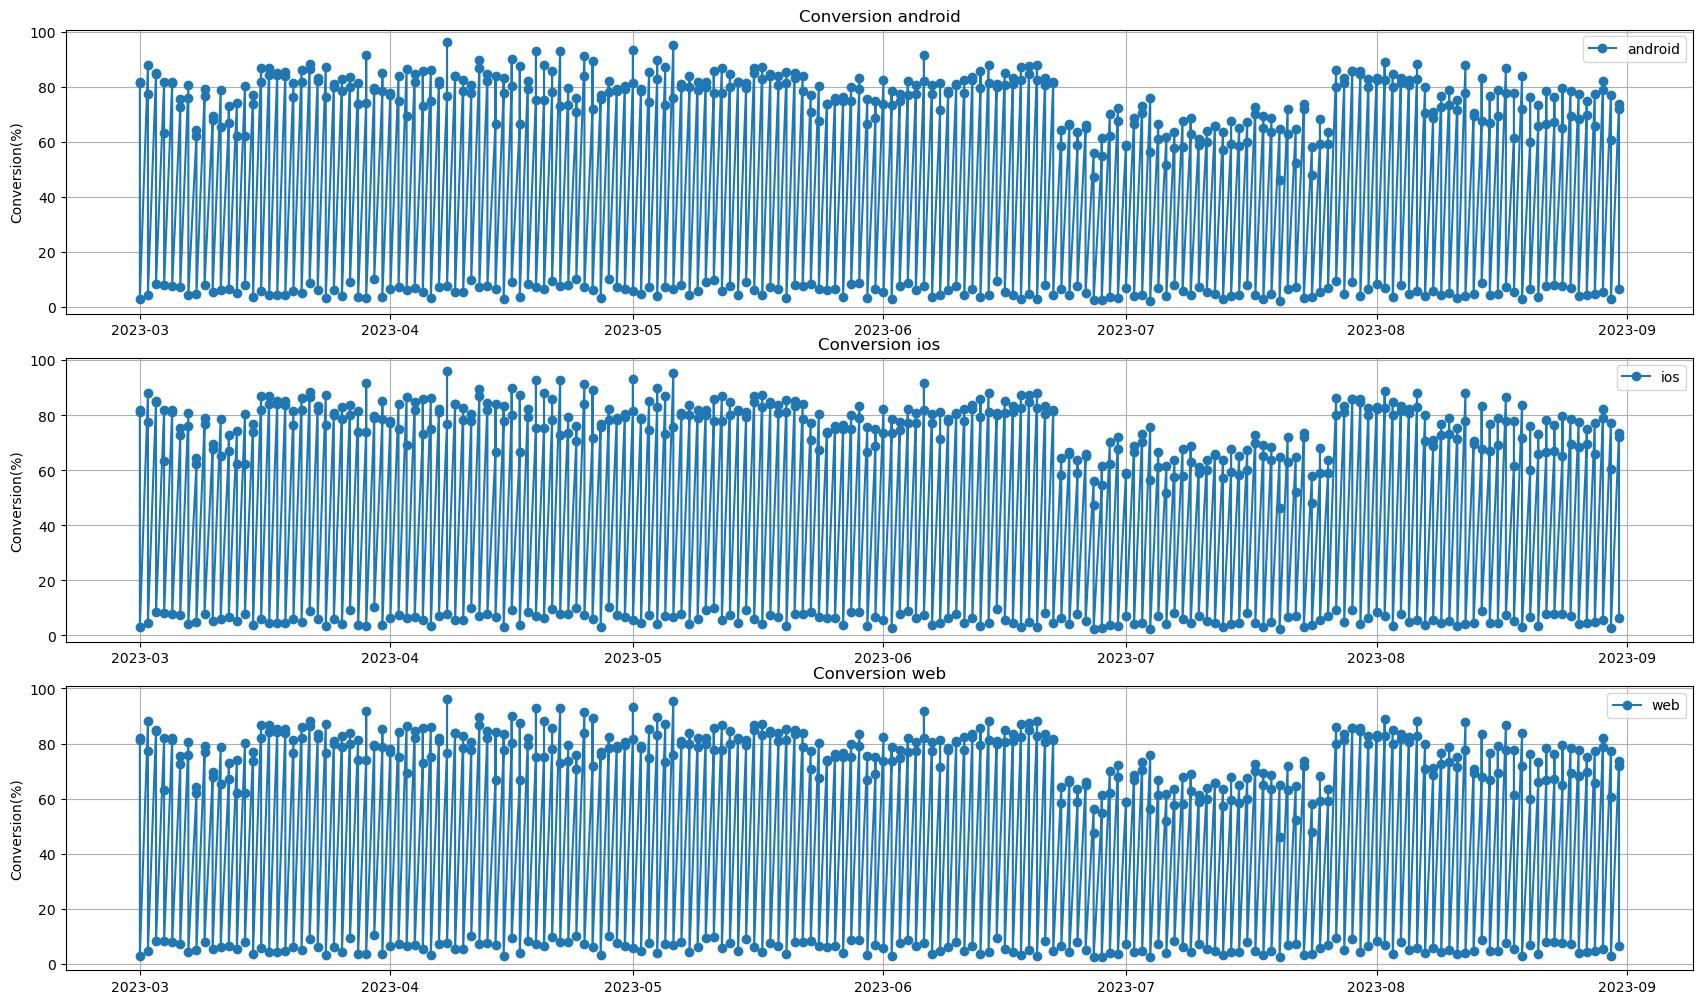

In [66]:
# конверсия по каждой платформе
fig, axes = plt.subplots(3, 1)
fig.set_size_inches(17, 10)
plt.tight_layout()

x = merged_df['date_group']
y = merged_df['conversion']

axes[0].plot(x, y, marker='o', label='android')
axes[0].legend()
axes[0].set_title('Conversion android')
axes[0].set_ylabel('Conversion(%)')
axes[0].grid()

axes[1].plot(x, y, marker='o', label='ios')
axes[1].legend()
axes[1].set_title('Conversion ios')
axes[1].set_ylabel('Conversion(%)')
axes[1].grid()

axes[2].plot(x, y, marker='o', label='web')
axes[2].legend()
axes[2].set_title('Conversion web')
axes[2].set_ylabel('Conversion(%)')
axes[2].grid()

plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/conversion by platforms.png')
plt.show()

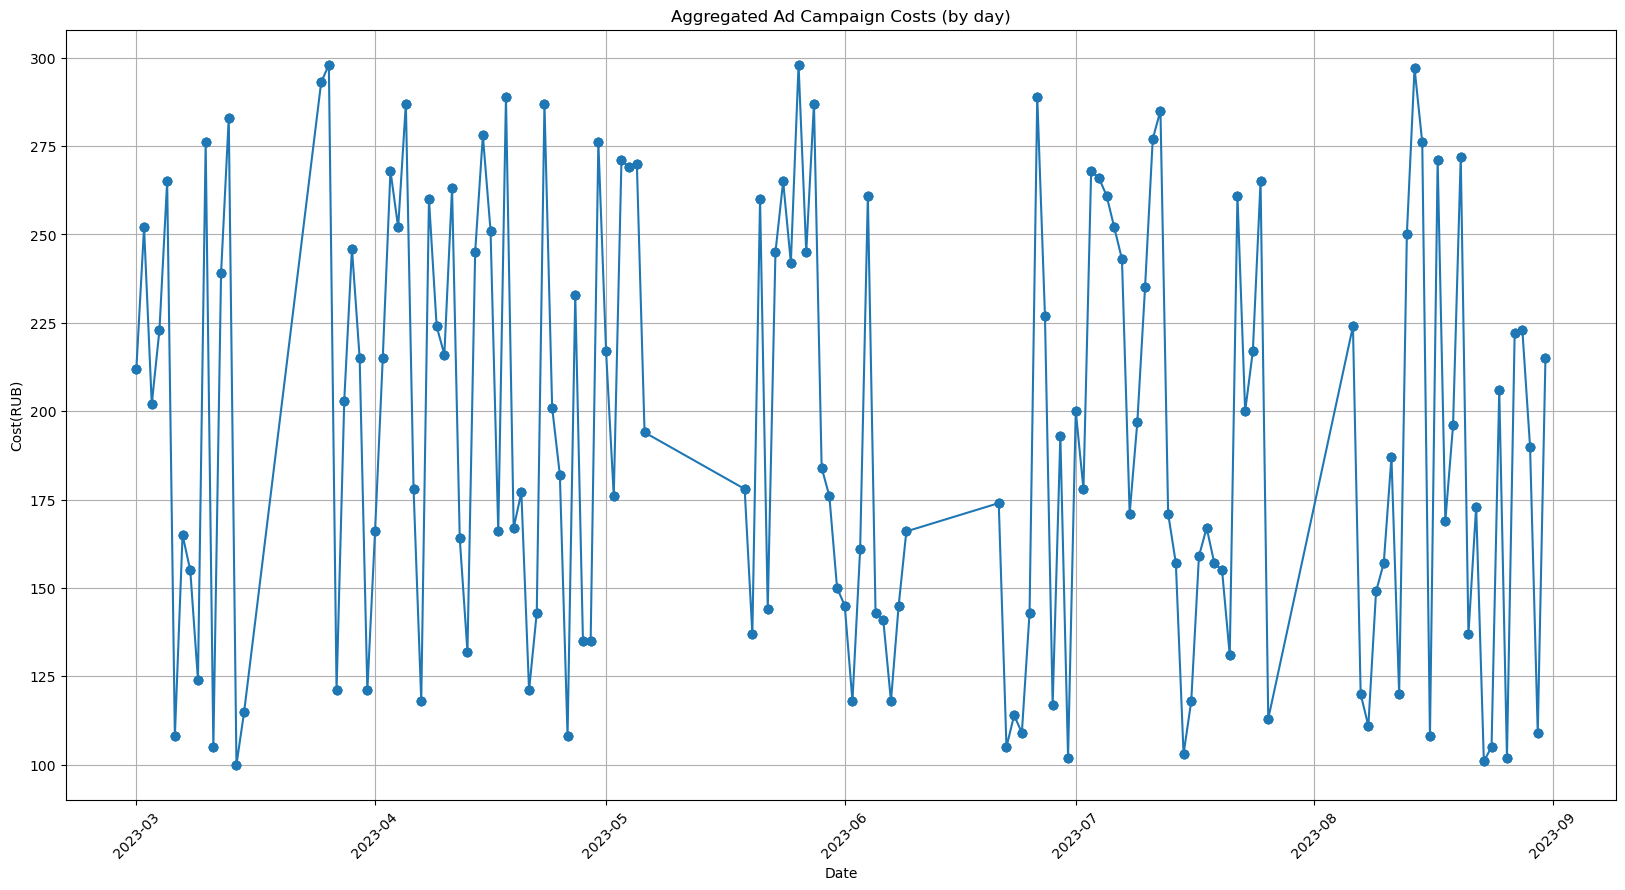

In [22]:
# стоимости реклам
plt.figure(figsize=(20, 10))
plt.title('Aggregated Ad Campaign Costs (by day)', fontsize=12)
x = data['date_group']
y = data['cost']
plt.plot(x, y, marker="o")
plt.title('Aggregated Ad Campaign Costs (by day)')
plt.xlabel('Date')
plt.ylabel('Cost(RUB)')
plt.xticks(rotation = 45)
plt.grid()
plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/agg by platforms.png')
plt.show()

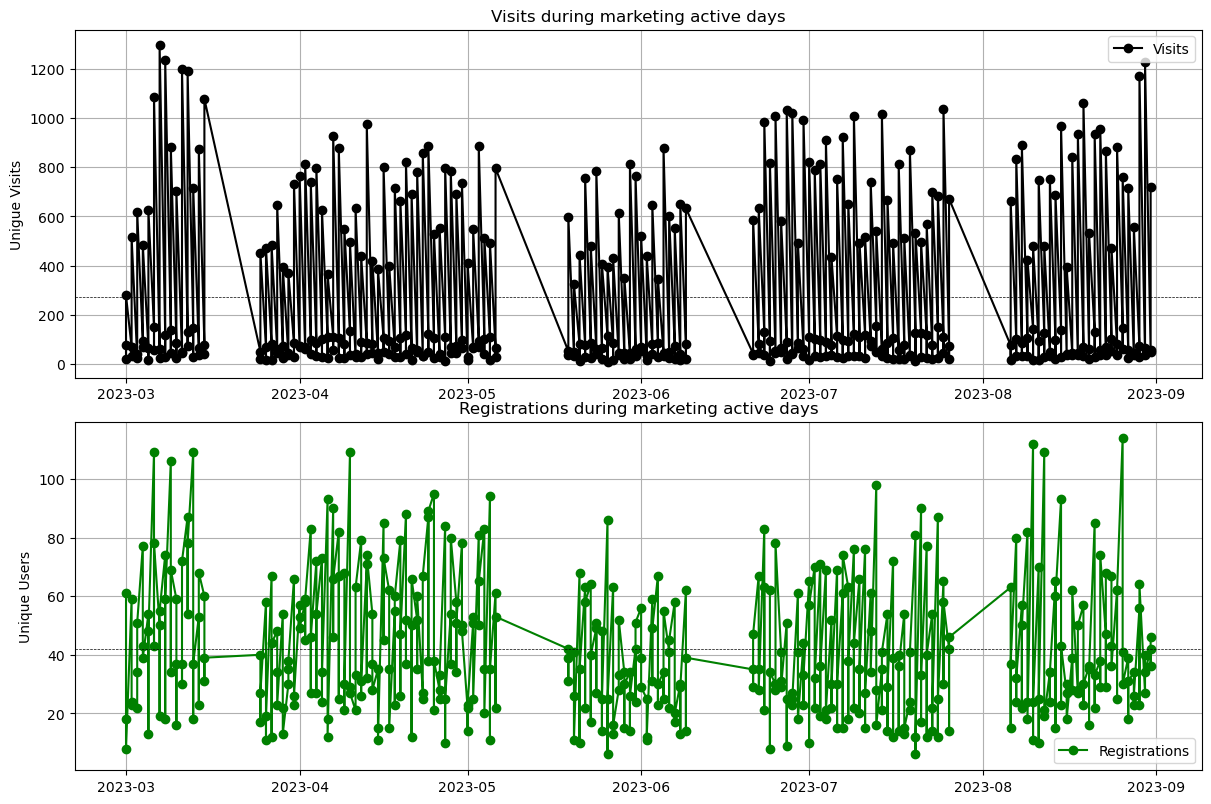

In [23]:
# визиты и регистрации с выделением рекламных кампаний 
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(12, 8)
plt.tight_layout()

axes[0].plot('date_group', 'visits', marker='o', color='black', label='Visits', data = data)
axes[0].legend()
axes[0].set_title('Visits during marketing active days')
axes[0].set_ylabel('Unigue Visits')
axes[0].grid()
axes[0].axhline(data['visits'].mean(),  color='black', linestyle='--', linewidth=0.5)

axes[1].plot('date_group', 'registrations', marker='o', color='green', label='Registrations', data=data)
axes[1].legend()
axes[1].set_title('Registrations during marketing active days')
axes[1].set_ylabel('Unique Users')
axes[1].grid()
axes[1].axhline(data['registrations'].mean(),  color='black', linestyle='--', linewidth=0.5)

plt.show()

**-------------------------------------------------------------------------------------**

In [25]:
merged_df

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.33
1,2023-03-01,ios,22,18,81.82
2,2023-03-01,web,279,8,2.87
3,2023-03-02,android,67,59,88.06
4,2023-03-02,ios,31,24,77.42
...,...,...,...,...,...
547,2023-08-30,ios,66,40,60.61
548,2023-08-30,web,1227,34,2.77
549,2023-08-31,android,57,42,73.68
550,2023-08-31,ios,50,36,72.00


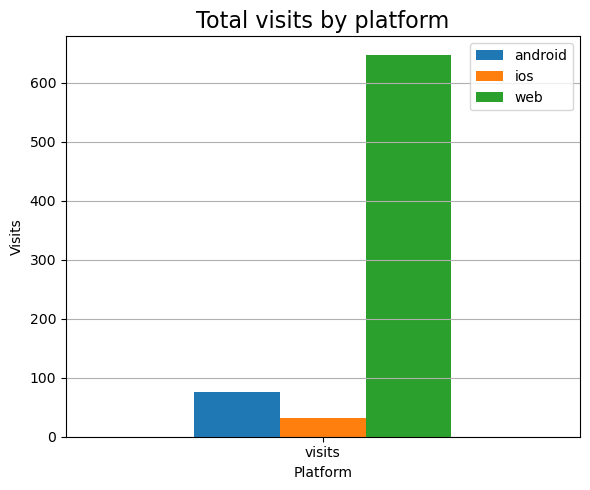

In [26]:
#визиты по платформам
def visits_by_platform_chart(df):
    fig, ax = plt.subplots(figsize=(6,5))
    df = merged_df.pivot_table(columns='platform', values='visits')
    df.plot(kind='bar', ax=ax)
    plt.title('Total visits by platform', fontsize=16)
    plt.xlabel('Platform',fontsize=10)
    plt.ylabel('Visits',fontsize=10)
    plt.legend(loc='upper right')
    plt.xticks(rotation=360)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/total visits by platforms.png')
    plt.show()

visits_by_platform_chart(merged_df)

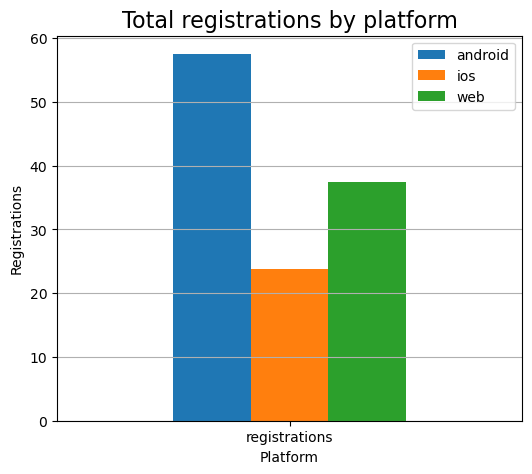

In [27]:
#регистрации по платформам
def regs_by_platform_chart(df):
    fig, ax = plt.subplots(figsize=(6,5))
    df = merged_df.pivot_table(columns='platform', values='registrations')
    df.plot(kind='bar', ax=ax)
    plt.title('Total registrations by platform', fontsize=16)
    plt.xlabel('Platform',fontsize=10)
    plt.ylabel('Registrations',fontsize=10)
    plt.legend(loc='upper right')
    plt.xticks(rotation=360)
    plt.grid(axis='y')
    plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/total regs by platforms.png')
    plt.show()

regs_by_platform_chart(merged_df)

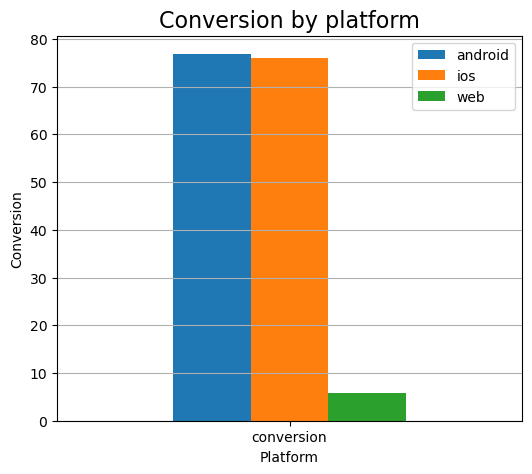

In [28]:
#конверсии по платформам
def conv_by_platform_chart(df):
    fig, ax = plt.subplots(figsize=(6,5))
    df = merged_df.pivot_table(columns='platform', values='conversion')
    df.plot(kind='bar', ax=ax)
    plt.title('Conversion by platform', fontsize=16)
    plt.xlabel('Platform',fontsize=10)
    plt.ylabel('Conversion',fontsize=10)
    plt.legend(loc='upper right')
    plt.xticks(rotation=360)
    plt.grid(axis='y')
    plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/total conversion by platforms.png')
    plt.show()

conv_by_platform_chart(merged_df)

In [29]:
data

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,75,61,212,advanced_algorithms_series
1,2023-03-01,22,18,212,advanced_algorithms_series
2,2023-03-01,279,8,212,advanced_algorithms_series
3,2023-03-02,67,59,252,advanced_algorithms_series
4,2023-03-02,31,24,252,advanced_algorithms_series
...,...,...,...,...,...
421,2023-08-30,66,40,109,intro_to_python_course
422,2023-08-30,1227,34,109,intro_to_python_course
423,2023-08-31,57,42,215,intro_to_python_course
424,2023-08-31,50,36,215,intro_to_python_course


C:\Users\kolgi\AppData\Local\Temp\ipykernel_16012\2077508902.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


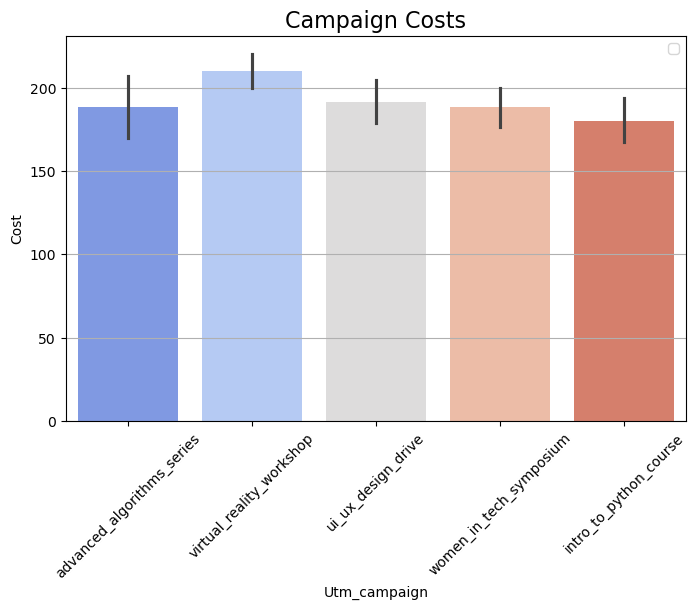

In [30]:
# стоимости рекламных кампаний
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x='utm_campaign', y='cost', hue='utm_campaign', data=data, ax=ax, palette="coolwarm")
plt.title('Campaign Costs', fontsize=16)
plt.xlabel('Utm_campaign',fontsize=10)
plt.ylabel('Cost',fontsize=10)
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/cost by utm_campaign.png')
plt.show()

C:\Users\kolgi\AppData\Local\Temp\ipykernel_16012\3780343207.py:7: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



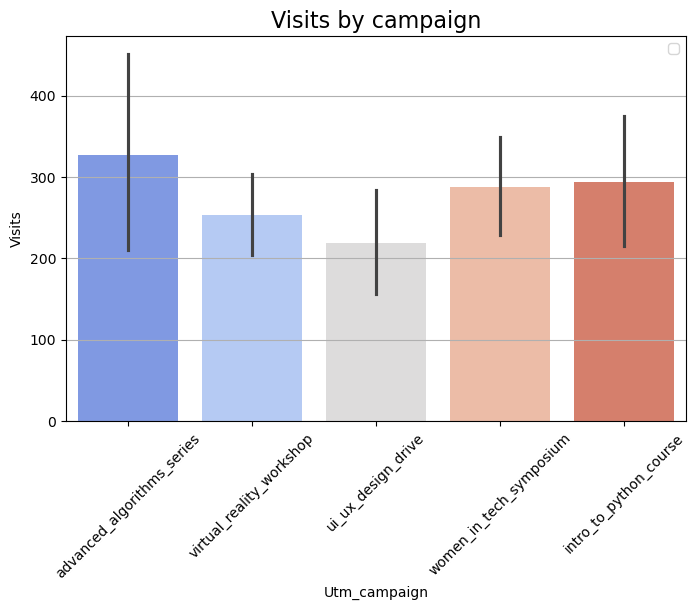

In [84]:
# визиты по кампаниям
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x='utm_campaign', y='visits', hue='utm_campaign', data=data, ax=ax, palette="coolwarm")
plt.title('Visits by campaign', fontsize=16)
plt.xlabel('Utm_campaign',fontsize=10)
plt.ylabel('Visits',fontsize=10)
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/vis by campaign.png')
plt.show()

C:\Users\kolgi\AppData\Local\Temp\ipykernel_16012\1542035410.py:7: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



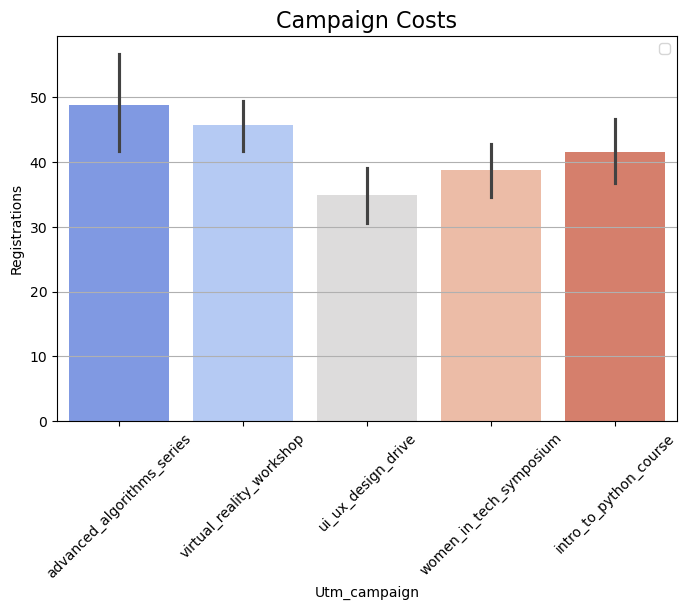

In [86]:
# стоимости рекламных кампаний
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x='utm_campaign', y='registrations', hue='utm_campaign', data=data, ax=ax, palette="coolwarm")
plt.title('Campaign Costs', fontsize=16)
plt.xlabel('Utm_campaign',fontsize=10)
plt.ylabel('Registrations',fontsize=10)
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.savefig('C:/Users/kolgi/OneDrive/Рабочий стол/data-analytics-project-100/charts/regs by campaign.png')
plt.show()